In [0]:
# Import the machine learning libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [0]:
# Load the MNIST dataset.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [55]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


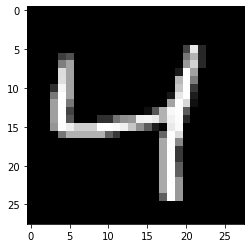

In [56]:
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))

In [57]:
X_train = X_train/255
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.
print(X_train.min(), X_train.max())

-1.0 1.0


In [58]:
# For faster training on smaller dataset
only_zeros = X_train[y_train==0]
print(only_zeros.shape)

(5923, 28, 28, 1)


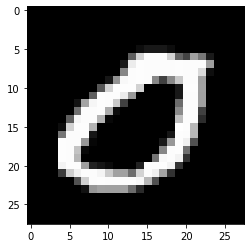

In [59]:
plt.imshow(only_zeros[70].reshape(28, 28), cmap=plt.get_cmap('gray'))

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

In [0]:
np.random.seed(42)
tf.random.set_seed(42)
codings_size = 100

In [0]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))

In [0]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [0]:
GAN = Sequential([generator, discriminator])

In [0]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [0]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [67]:
GAN.layers

In [68]:
GAN.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [69]:
GAN.layers[0].summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
______________________________________________

In [70]:
GAN.layers[1].summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 0
Non-trainable params: 212,865
________________________________________________

In [0]:
batch_size = 32
my_data = X_train
#my_data = only_zeros # For faster training on smaller dataset

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [73]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [0]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [0]:
epochs = 20

In [76]:
# Training Loop.
%%time

# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")

Currently on Epoch 1
	Currently on batch number 100 of 1875
	Currently on batch number 200 of 1875
	Currently on batch number 300 of 1875
	Currently on batch number 400 of 1875
	Currently on batch number 500 of 1875
	Currently on batch number 600 of 1875
	Currently on batch number 700 of 1875
	Currently on batch number 800 of 1875
	Currently on batch number 900 of 1875
	Currently on batch number 1000 of 1875
	Currently on batch number 1100 of 1875
	Currently on batch number 1200 of 1875
	Currently on batch number 1300 of 1875
	Currently on batch number 1400 of 1875
	Currently on batch number 1500 of 1875
	Currently on batch number 1600 of 1875
	Currently on batch number 1700 of 1875
	Currently on batch number 1800 of 1875
Currently on Epoch 2
	Currently on batch number 100 of 1875
	Currently on batch number 200 of 1875
	Currently on batch number 300 of 1875
	Currently on batch number 400 of 1875
	Currently on batch number 500 of 1875
	Currently on batch number 600 of 1875
	Currently on

In [77]:
noise = tf.random.normal(shape=[10, codings_size])
noise.shape

TensorShape([10, 100])

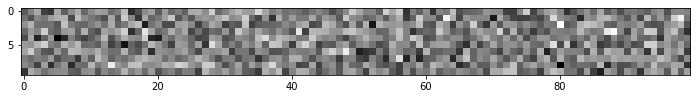

In [78]:
plt.figure(figsize=(12, 3))
plt.imshow(noise, cmap=plt.get_cmap('gray'))

In [79]:
%%time
images = generator(noise)

CPU times: user 30.9 ms, sys: 0 ns, total: 30.9 ms
Wall time: 31.6 ms


In [0]:
single_image = images[0]

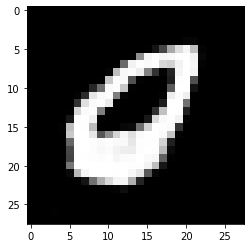

In [81]:
plt.imshow(single_image.numpy().reshape(28,28), cmap=plt.get_cmap('gray'))

In [82]:
image.shape

TensorShape([10, 28, 28, 1])

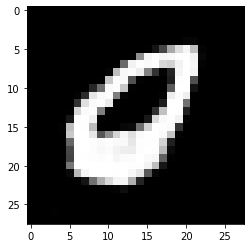

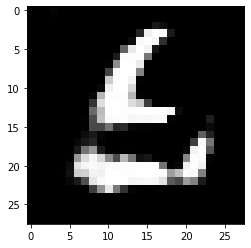

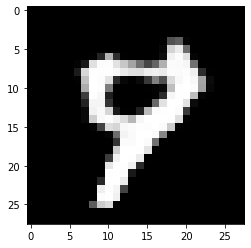

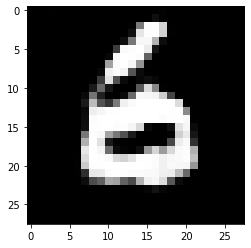

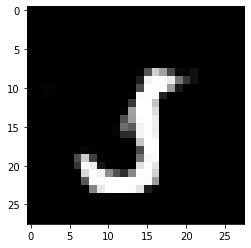

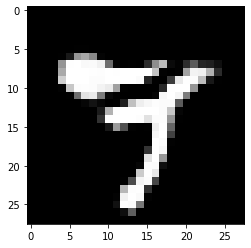

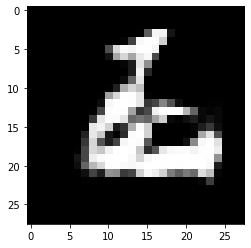

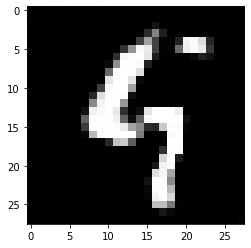

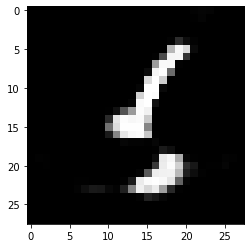

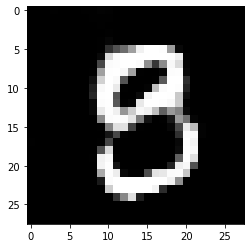

In [83]:
# Visulize.
for image in images:
    plt.imshow(image.numpy().reshape(28,28), cmap='gray')
    plt.show()